In [1]:
#%reset

In [2]:
import pandas as pd
%pylab inline
import seaborn as sns
sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


# Load data

In [3]:
customers_data = pd.read_csv('customers_data.csv', decimal=',', index_col=0)

In [4]:
customers_data['order_purchase_timestamp']

0        2017-09-13 08:59:02
1        2017-06-28 11:52:20
2        2018-05-18 10:25:53
3        2017-08-01 18:38:42
4        2017-08-10 21:48:40
                ...         
94715    2017-09-03 17:20:56
94716    2018-07-23 16:24:27
94717    2018-07-26 09:13:04
94718    2017-08-11 10:15:22
94719    2018-04-12 19:47:40
Name: order_purchase_timestamp, Length: 94720, dtype: object

## Decompose columns in groups

In [5]:
selected_columns = ['order_id', 'order_item_id', 'freight_value', 'review_score', 
                    'dist_to_seller', 'payment_value', 'product_photos_qty', 
                    'comment_propensity']

# Define clusters number
clusters_n = 7

# Evaluate columns type impact on clustering

## Kmeans on variable with Kmeans result high dispersion

In [6]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# Create scaled dataframe
dataframe = customers_data[selected_columns]
dataframe_scaled = preprocessing.StandardScaler().fit_transform(dataframe)
dataframe_scaled = pd.DataFrame(dataframe_scaled, columns=dataframe.columns)

# Apply KMeans on scaled dataframe
clusterer = KMeans(n_clusters=clusters_n).fit(dataframe_scaled)

# Create customer groups from clustering

In [7]:
groups_data = [(id, dataframe[clusterer.labels_ == id])
               for id in set(clusterer.labels_)]
group_descriptions = [(group[0], group[1].describe())
                      for group in groups_data]

group_mean = pd.DataFrame()

for col in dataframe.columns:
    for des in group_descriptions:
        group_mean.loc[des[0], col] = des[1].loc['mean', col]

group_mean['cluster_size'] = [sum(clusterer.labels_ == id)
                              for id in set(clusterer.labels_)]

mean_std_df = pd.DataFrame(index=['mean', 'std'], columns=dataframe.columns)
mean_std_df.loc['mean', :] = dataframe.mean().values
mean_std_df.loc['std', :] = dataframe.std().values
mean_std_df.loc['mean','cluster_size'] = group_mean['cluster_size'].mean()
mean_std_df.loc['std','cluster_size'] = group_mean['cluster_size'].std()

group_mean.style.apply(
    lambda x: ["background: lightgreen"
               if v > (mean_std_df.loc['mean', x.name] + mean_std_df.loc['std', x.name])
               else "" for v in x], axis=0).apply(
    lambda x: ["background: coral"
               if v < (mean_std_df.loc['mean', x.name] - mean_std_df.loc['std', x.name])
               else "" for v in x], axis=0)

,order_id,order_item_id,freight_value,review_score,dist_to_seller,payment_value,product_photos_qty,comment_propensity,cluster_size
0,1.000000,1.064596,17.980504,4.612659,405.393021,126.702403,1.542651,2.256596,51474
1,1.000000,1.151344,21.784248,1.820591,530.261737,151.905408,1.957538,17.785230,13433
2,1.015093,3.738072,70.535891,3.407254,560.835388,337.414830,1.830098,8.097614,2054
3,1.000074,1.047475,18.653441,4.469359,441.715783,136.755543,5.388748,2.979105,13544
4,1.000000,1.056188,35.258204,4.202703,1917.693899,179.096035,2.140356,3.849726,9842
5,2.115629,1.170777,22.473823,4.169305,556.077754,139.860392,2.074897,4.575732,2828
6,1.005825,1.281553,99.722472,3.894498,899.368632,1338.742456,2.727110,7.196440,1545


# Update Frequency

In [8]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from datetime import datetime
from datetime import timedelta

def object_to_datetime(_x):
    if pd.isnull(_x) == False:
        return datetime.strptime(_x, '%Y-%m-%d %H:%M:%S')
    else:
        return np.nan

customers_data['date'] = customers_data['order_purchase_timestamp'].apply(
    lambda x: object_to_datetime(x))

In [9]:
from sklearn.metrics.cluster import adjusted_rand_score

# Get first and last purchase dates
first_date = customers_data['date'].min()
last_date = customers_data['date'].max()
# Process middle purchase date
middle_date = first_date + (last_date-first_date)/2

# APPLY CLUSTERING ON INITIAL DATA
# Get first half dataframe according purchase date
initial_df = customers_data.loc[customers_data['date']
                                < middle_date, selected_columns]
# Create scaled dataframe
initial_df_scaled = preprocessing.StandardScaler(
).fit_transform(initial_df)
initial_df_scaled = pd.DataFrame(
    initial_df_scaled, columns=initial_df.columns)
# Apply KMeans on scaled dataframe
initial_clusterer = KMeans(n_clusters=clusters_n,
                           random_state=0).fit(initial_df_scaled)

# WHILE LOOP to create dataframe with 15 days more and compare labelisation
# between initial clusterer and current clusterer
results = pd.DataFrame(columns=['begin', 'end', 'size', 'similarity score'])
current_date = middle_date
cpt = 0
cluster_params = pd.DataFrame(columns=['date', 'group id', 'param', 'mean'])
while current_date < last_date:
    # Save precedent date
    precedent_date = current_date
    # Add 15 day to current day
    current_date = current_date + timedelta(days=15)

    # TRAIN CLUSTERER ON CURRENT DATA
    # Create current df with data of the last 15 days
    current_df = customers_data.loc[(precedent_date < customers_data['date']) & (
        customers_data['date'] < current_date), selected_columns]
    # if case when current dataframe is too small
    if len(current_df) < 7:
        continue
    # Create scaled current df
    current_df_scaled = preprocessing.StandardScaler().fit_transform(current_df)
    current_df_scaled = pd.DataFrame(
        current_df_scaled, columns=dataframe.columns)
    # Apply KMeans on scaled df that have data of the last 15 days
    current_clusterer = KMeans(
        n_clusters=clusters_n, random_state=0).fit(current_df_scaled)

    # PREDICT WITH INITIAL AND CURRENT CLUSTERER
    # Predict label for the df of the last 15 days with initial clusterer
    label_with_initial = initial_clusterer.predict(current_df_scaled)
    # Predict label for the df of the last 15 days with current clusterer
    label_with_current = current_clusterer.predict(current_df_scaled)

    # COMPARE RESULTS
    # Get score to compare labels lists of initial and current clusterer
    score = adjusted_rand_score(label_with_initial, label_with_current)
    # Save results
    results.loc[cpt, :] = [precedent_date.date(), current_date.date(),
                           len(current_df_scaled), score]

    cpt = cpt+1

results

,begin,end,size,similarity score
0,2017-09-04,2017-09-19,2104,0.950165
1,2017-09-19,2017-10-04,2011,0.959747
2,2017-10-04,2017-10-19,2168,0.731722
3,2017-10-19,2017-11-03,1966,0.957593
4,2017-11-03,2017-11-18,2469,0.983538
5,2017-11-18,2017-12-03,4933,0.925995
6,2017-12-03,2017-12-18,3166,0.945074
7,2017-12-18,2018-01-02,1848,0.966764
8,2018-01-02,2018-01-17,3546,0.962058
9,2018-01-17,2018-02-01,3313,0.976001


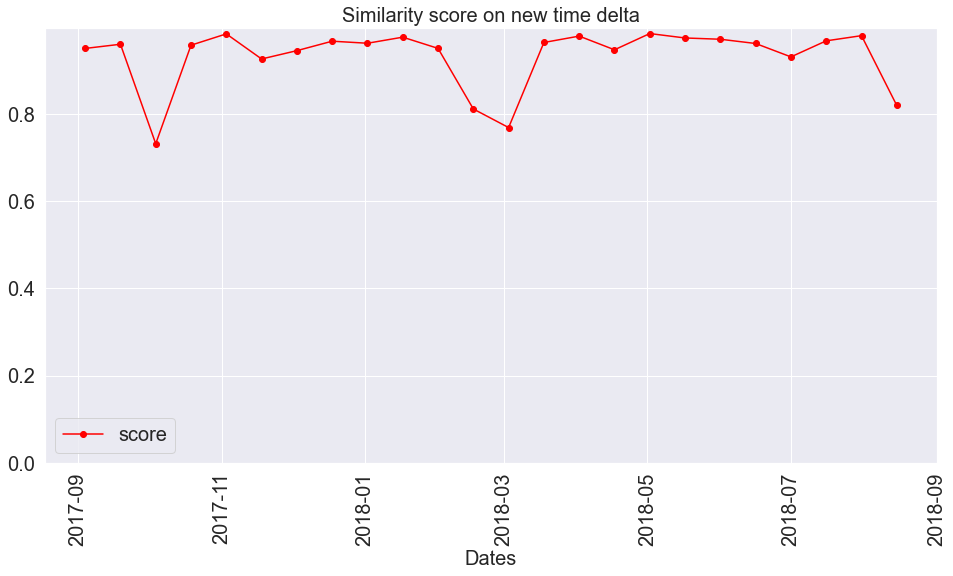

In [10]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

# First plot
ax.plot(results['begin'],
        results['similarity score'], color='red', marker='o', label='score')
plt.yticks(size=20)


plt.xticks(size=20, rotation=90)

# X tick label shapping
ax.set_xlabel('Dates', fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add title
plt.title('Similarity score on new time delta', fontsize=20)
ax.set_ylim(ymin=0)
plt.show()

In [11]:
# Draft
high_value_bool_df = group_mean.apply(lambda x: [True if v > (
    mean_std_df.loc['mean', x.name] + mean_std_df.loc['std', x.name]) else False for v in x])
low_value_bool_df = group_mean.apply(lambda x: [True if v < (
    mean_std_df.loc['mean', x.name] - mean_std_df.loc['std', x.name]) else False for v in x])

cluster_params = pd.DataFrame(columns=['group id', 'param', 'mean'])
for id in group_mean.index:
    if high_value_bool_df.loc[id, :].sum():
        for param in list(group_mean.loc[id, high_value_bool_df.loc[id, :]].index):
            new_row = pd.Series(data={'group id': id, 'param': param,
                                'mean': group_mean.loc[id, high_value_bool_df.loc[id, :]][param]})
            cluster_params = cluster_params.append(new_row, ignore_index=True)

    if low_value_bool_df.loc[id,:].sum():
        for param in list(group_mean.loc[id, low_value_bool_df.loc[id, :]].index):
            new_row = pd.Series(data={'group id': id, 'param': param,
                                'mean': group_mean.loc[id, low_value_bool_df.loc[id, :]][param]})
            cluster_params = cluster_params.append(new_row, ignore_index=True)


print(group_mean)

   order_id  order_item_id  freight_value  review_score  dist_to_seller  \
0  1.000000       1.064596      17.980504      4.612659      405.393021   
1  1.000000       1.151344      21.784248      1.820591      530.261737   
2  1.015093       3.738072      70.535891      3.407254      560.835388   
3  1.000074       1.047475      18.653441      4.469359      441.715783   
4  1.000000       1.056188      35.258204      4.202703     1917.693899   
5  2.115629       1.170777      22.473823      4.169305      556.077754   
6  1.005825       1.281553      99.722472      3.894498      899.368632   

   payment_value  product_photos_qty  comment_propensity  cluster_size  
0     126.702403            1.542651            2.256596         51474  
1     151.905408            1.957538           17.785230         13433  
2     337.414830            1.830098            8.097614          2054  
3     136.755543            5.388748            2.979105         13544  
4     179.096035            2.1403